<a href="https://colab.research.google.com/github/scardenol/RP_argos/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and prefs

In [115]:
import sympy as sp
from sympy import symbols, init_printing, Function, sympify, Derivative, simplify, ordered
init_printing(use_latex='mathjax') # Printing preferences
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt #gráficas
import matplotlib as mpl
import seaborn as sns #gráficas
plt.style.use('seaborn') #estilo de graficas

# Read Data

# Model

In [116]:
def Taylor_polynomial_sympy(function_expression, variable_list, evaluation_point, degree):
    """
    Mathematical formulation reference:
    https://math.libretexts.org/Bookshelves/Calculus/Supplemental_Modules_(Calculus)/Multivariable_Calculus/3%3A_Topics_in_Partial_Derivatives/Taylor__Polynomials_of_Functions_of_Two_Variables
    :param function_expression: Sympy expression of the function
    :param variable_list: list. All variables to be approximated (to be "Taylorized")
    :param evaluation_point: list. Coordinates, where the function will be expressed
    :param degree: int. Total degree of the Taylor polynomial
    :return: Returns a Sympy expression of the Taylor series up to a given degree, of a given multivariate expression, approximated as a multivariate polynomial evaluated at the evaluation_point
    """
    from sympy import factorial, Matrix, prod
    import itertools

    n_var = len(variable_list)
    point_coordinates = [(i, j) for i, j in (zip(variable_list, evaluation_point))]  # list of tuples with variables and their evaluation_point coordinates, to later perform substitution

    deriv_orders = list(itertools.product(range(degree + 1), repeat=n_var))  # list with exponentials of the partial derivatives
    deriv_orders = [deriv_orders[i] for i in range(len(deriv_orders)) if sum(deriv_orders[i]) <= degree]  # Discarding some higher-order terms
    n_terms = len(deriv_orders)
    deriv_orders_as_input = [list(sum(list(zip(variable_list, deriv_orders[i])), ())) for i in range(n_terms)]  # Individual degree of each partial derivative, of each term

    polynomial = 0
    for i in range(n_terms):
        partial_derivatives_at_point = function_expression.diff(*deriv_orders_as_input[i]).subs(point_coordinates)  # e.g. df/(dx*dy**2)
        denominator = prod([factorial(j) for j in deriv_orders[i]])  # e.g. (1! * 2!)
        distances_powered = prod([(Matrix(variable_list) - Matrix(evaluation_point))[j] ** deriv_orders[i][j] for j in range(n_var)])  # e.g. (x-x0)*(y-y0)**2
        polynomial += partial_derivatives_at_point / denominator * distances_powered
    return polynomial

In [117]:
def Model_taylor_sympy(taylor_serie):
  """
  param taylor_serie: taylor serie to be converted to model
  return: list of model termns
  """
  from sympy import symbols, init_printing, Function, sympify, Derivative, simplify, ordered

  # Convert Serie to list
  S = list(sympify((sympify(taylor_serie, evaluate=False)).args))
  M = S.copy() # Copy the list to use for the model

  # Check for derivatives
  # Substitue derivatives from Serie List with parameters (cleaner than from Serie)
  d = [list(i.atoms(Derivative)) for i in M]
  d_unpacked = [x for l in d for x in l] # this unpacks it but gets messy if a list had more than 1 element
  
  # if d_unpacked is empty it means there are no derivatives in the serie
  B = [];

  if len(d_unpacked) != 0:  # if there are derivatives
    indexes = [idx for idx in range(len(d)) if len(d[idx])] # Get indexes

    for i in indexes:
      B_aux = sympify(['b' + str(b) for b in range(len(B), len(B) + 1)])
      B += B_aux
      M[i] = simplify(M[i].subs(list(ordered(d[i]))[0], B_aux[0]))
    
    # Clean the f(c) termn at the end
    B_aux = sympify(['b' + str(b) for b in range(len(B), len(B) + 1)])
    B += B_aux
    M[-1] = B_aux[0]

    # Multiply resulting list with the parameter list A (excluding the last element which has only 1 parameter)
    A = sympify(['a' + str(a) for a in range(0, len(B)-1)])
    M = [a*m for a,m in zip(A,M[:-1])] + [M[-1]]
  
  else: # If there are not derivatives
    # Multiply resulting list with the parameter list A
    A = sympify(['a' + str(a) for a in range(0, len(M))])
    M = [a*m for a,m in zip(A,M)]
  
  return M, A, B

In [118]:
# Model F(x1, x2, ..., xn) where n is n_vars
# x1, x2, x3 = symbols('x1, x2, x3')
n_vars = 3
variable_list = list(range(1,n_vars+1)) # List of variable indexes
variable_list = [symbols('x' + str(i)) for i in variable_list] # List of symbolic variables
f = Function('f')
# function_expression = f(x1*x2*x3)
function_expression = f(np.prod(variable_list))
# variable_list = [x1,x2,x3]
evaluation_point = [1, 2, 3]
degree=2
F = Taylor_polynomial_sympy(function_expression, variable_list, evaluation_point, degree)
display(F)


                                                                              
                                                                              
                                                                              
             ⎛  2        ⎞│                         ⎛                         
           2 ⎜ d         ⎟│                         ⎜  ⎛ d        ⎞│          
18⋅(x₁ - 1) ⋅⎜────(f(ξ₁))⎟│     + (x₁ - 1)⋅(x₂ - 2)⋅⎜3⋅⎜───(f(ξ₁))⎟│     + 18⋅
             ⎜   2       ⎟│                         ⎜  ⎝dξ₁       ⎠│ξ₁=6      
             ⎝dξ₁        ⎠│ξ₁=6                     ⎝                         

                                                                              
                                                                              
                                                                              
⎛  2        ⎞│    ⎞                     ⎛                         ⎛  2        
⎜ d         ⎟│    ⎟                     ⎜  ⎛ d     

In [119]:
# Generate the model
M, A, B = Model_taylor_sympy(F)

In [120]:
# Display results
F_list = list(sympify((sympify(F, evaluate=False)).args))
display(F_list) # Original
display(M) # model
print(len(F_list) == len(M))
display(A, B) # Parameters
parameters = A + B
display(parameters) # List of all parameters

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢            ⎛  2        ⎞│                                                   
⎢          2 ⎜ d         ⎟│                 ⎛ d        ⎞│                 ⎛ d 
⎢2⋅(x₃ - 3) ⋅⎜────(f(ξ₁))⎟│    , 2⋅(x₃ - 3)⋅⎜───(f(ξ₁))⎟│    , 3⋅(x₂ - 2)⋅⎜───
⎢            ⎜   2       ⎟│                 ⎝dξ₁       ⎠│ξ₁=6             ⎝dξ₁
⎣            ⎝dξ₁        ⎠│ξ₁=6                                               

                                                                              
                                                                              
                                                                              
                                                          ⎛  2        ⎞│      
       ⎞│                 ⎛ d        ⎞│            

⎡                                                                             
⎢                2                                                            
⎢2⋅a₀⋅b₀⋅(x₃ - 3) , 2⋅a₁⋅b₁⋅(x₃ - 3), 3⋅a₂⋅b₂⋅(x₂ - 2), 6⋅a₃⋅b₃⋅(x₁ - 1), 18⋅a
⎣                                                                             

                                2                                             
             2  9⋅a₅⋅b₅⋅(x₂ - 2)                                              
₄⋅b₄⋅(x₁ - 1) , ─────────────────, 2⋅a₆⋅b₆⋅(x₁ - 1)⋅(x₃ - 3), 3⋅a₇⋅b₇⋅(x₁ - 1)
                        2                                                     

                                      ⎤
                                      ⎥
⋅(x₂ - 2), a₈⋅b₈⋅(x₂ - 2)⋅(x₃ - 3), b₉⎥
                                      ⎦

True


[a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈]

[b₀, b₁, b₂, b₃, b₄, b₅, b₆, b₇, b₈, b₉]

[a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, b₀, b₁, b₂, b₃, b₄, b₅, b₆, b₇, b₈, b₉]

In [121]:
# Convert list back to sum
model = sum(M)
display(model)

                                                                              
                2                                                             
2⋅a₀⋅b₀⋅(x₃ - 3)  + 2⋅a₁⋅b₁⋅(x₃ - 3) + 3⋅a₂⋅b₂⋅(x₂ - 2) + 6⋅a₃⋅b₃⋅(x₁ - 1) + 1
                                                                              

                                    2                                         
                2   9⋅a₅⋅b₅⋅(x₂ - 2)                                          
8⋅a₄⋅b₄⋅(x₁ - 1)  + ───────────────── + 2⋅a₆⋅b₆⋅(x₁ - 1)⋅(x₃ - 3) + 3⋅a₇⋅b₇⋅(x
                            2                                                 

                                              
                                              
₁ - 1)⋅(x₂ - 2) + a₈⋅b₈⋅(x₂ - 2)⋅(x₃ - 3) + b₉
                                              

In [122]:
vars = variable_list + parameters
display(vars) # Order of function parameters
fun = sp.lambdify(vars, model, 'numpy')
value = [i for i in range(len(vars))]
fun(*[1]*len(vars))

[x₁, x₂, x₃, a₀, a₁, a₂, a₃, a₄, a₅, a₆, a₇, a₈, b₀, b₁, b₂, b₃, b₄, b₅, b₆, b
₇, b₈, b₉]

8.5

# Genetic Algorithm

In [123]:
import numpy as np

"""
Based on the simple (non-vectorial) GA from https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6
"""

def mse(A,B): # Cleanest way to calculate Mean Square Error
  return np.square(np.subtract(A, B)).mean()

def cal_pop_fitness(equation_inputs, pop, Y, fun):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    Y_bar = [[fun(*[item[i] for item in equation_inputs], *pop[j]) for i in range(len(equation_inputs[0]))] for j in range(len(pop))]
    fitness = [mse(Y_bar[i], Y) for i in range(len(Y))]
    return np.array(fitness)

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        min_fitness_idx = np.where(fitness == np.min(fitness))
        min_fitness_idx = min_fitness_idx[0][0]
        parents[parent_num, :] = pop[min_fitness_idx, :]
        fitness[min_fitness_idx] = 99999999999
    return parents

def crossover(parents, offspring_size): # One point crossover
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    # crossover_point = np.uint8(offspring_size[1]/2)
    import random
    crossover_point = random.randint(0, len(offspring_size)-1)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, num_mutations=1):
    mutations_counter = np.uint8(offspring_crossover.shape[1] / num_mutations)
    # Mutation changes a number of genes as defined by the num_mutations argument. The changes are random.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = mutations_counter - 1
        for mutation_num in range(num_mutations):
            # The random value to be added to the gene.
            random_value = np.random.uniform(-1.0, 1.0, 1) # Uniform mutation
            offspring_crossover[idx, gene_idx] = offspring_crossover[idx, gene_idx] + random_value
            gene_idx = gene_idx + mutations_counter
    return offspring_crossover

In [124]:
import numpy
import sympy as sp
"""
The y=target is to minimize the MSE of the model:
    y = w1x1^w2 + w3x2^w4
    where (x1,x2)=(4,-2)
    What are the best values for the 4 weights w1 to w4?
    We are going to use the genetic algorithm for the best possible values after a number of generations.
"""
# Model (equation)
# equation = 'w_1*x_1**w_2 + w_3*x_2**w_4 + w_5'
# y = sp.sympify(equation)
# vars = sp.sympify('[x_1, x_2, w_1, w_2, w_3, w_4, w_5]')
# y = sp.lambdify(vars, y, 'numpy')
y = fun

# Inputs of the equation.
# X_1 = [1,2,1.8,2.4,1.5,2.6]
# X_2 = [3,4,2.5,3.2,2.8,3.4]
N = 10 # number of observations
X_1 = np.random.uniform(low=1.0, high=3.0, size=N).tolist()
X_2 = np.random.uniform(low=2.0, high=4.0, size=N).tolist()
X_3 = np.random.uniform(low=3.0, high=5.0, size=N).tolist()
equation_inputs = [X_1, X_2, X_3]

# Observation
# Y = [18, 20, 17, 15, 11, 23]
# Y = np.random.uniform(low=10.0, high=25.0, size=N).tolist()
# ones = [1]*len(parameters)
ones = np.random.uniform(low=-1.0, high=1.0, size=len(parameters)).tolist()
Y = [fun(X_1[i], X_2[i], X_3[i], *ones) for i in range(len(X_1))]

# Number of the weights/parameters we are looking to optimize.
# num_weights = 5
num_weights = len(parameters)

"""
Genetic algorithm parameters:
    Mating pool size
    Population size
"""
sol_per_pop = 10
num_parents_mating = 5

# Defining the population size.
pop_size = (sol_per_pop,num_weights) # The population will have sol_per_pop chromosome where each chromosome has num_weights genes.
#Creating the initial population.
new_population = np.random.uniform(low=-1.0, high=1.0, size=pop_size)
print(new_population)

num_generations = 200

[[-0.91927708  0.053702    0.65012408 -0.74245804 -0.65890771  0.91794295
   0.16183114 -0.14234398 -0.86422354  0.0222635  -0.58869805  0.90904377
  -0.08001536 -0.96390353  0.81585251 -0.01056976  0.9169458  -0.90851806
   0.64286731]
 [ 0.26334301  0.67564339 -0.41551747  0.3615373   0.49969566 -0.1547436
  -0.65837012 -0.27777444  0.13555766 -0.76422451 -0.92912325  0.15861529
   0.24171463  0.22709038 -0.92142381  0.13303057  0.08396242  0.81384754
  -0.9107777 ]
 [ 0.69333987  0.72997753 -0.88501738 -0.95940784 -0.81465979  0.75576563
  -0.13712235  0.03388821  0.48978346  0.53550011 -0.78997704  0.43638158
   0.06301149 -0.29923214  0.34516391 -0.64786696 -0.17188964  0.17450948
   0.96778225]
 [ 0.558006   -0.30043795 -0.16169189 -0.69006274  0.64332784  0.46977878
  -0.65020161  0.12629534 -0.35531307  0.15423747 -0.35755469 -0.35371339
   0.86896142  0.05424596  0.51830453 -0.96074191 -0.71276557  0.99044888
   0.86076874]
 [ 0.68122333  0.73587956 -0.1527363   0.97708667 -0.

In [125]:
for generation in range(num_generations):
    print("Generation : ", generation)
    # Measing the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(equation_inputs, new_population, Y, y)
    print("Fitness: ", fitness)
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                      num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, 
                                    offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

    # The best result in the current iteration.
    print("Best result : ", np.min(cal_pop_fitness(equation_inputs, new_population, Y, y)))

# Getting the best solution after iterating finishing all generations.
#At first, the fitness is calculated for each solution in the final generation.
fitness = cal_pop_fitness(equation_inputs, new_population, Y, y)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.min(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])

Generation :  0
Fitness:  [1430.1994289   285.57265772  473.60703325  177.05869206   13.74881029
   17.71097132  495.75188234 1045.61440754 1030.26023153  243.45279477]
Best result :  11.215548805289021
Generation :  1
Fitness:  [ 13.74881029  17.71097132 177.05869206 243.45279477 285.57265772
  24.48511617 165.59470092 261.5811351  306.33069416  11.21554881]
Best result :  11.215548805289021
Generation :  2
Fitness:  [ 11.21554881  13.74881029  17.71097132  24.48511617 165.59470092
  18.38956745  22.68677017  28.8932861  174.78652493  11.53185968]
Best result :  7.462357591435639
Generation :  3
Fitness:  [11.21554881 11.53185968 13.74881029 17.71097132 18.38956745 15.61998243
 17.02195622 24.19966622 14.89247504  7.46235759]
Best result :  7.462357591435639
Generation :  4
Fitness:  [ 7.46235759 11.21554881 11.53185968 13.74881029 14.89247504 11.41677833
  9.61323537 18.29120109 11.212447    9.16640603]
Best result :  5.52303398638548
Generation :  5
Fitness:  [ 7.46235759  9.1664060

In [126]:
best_w = (new_population[best_match_idx, :].tolist())[0][0]
print(best_w)
X = equation_inputs
Y_bar_GA = [y(*[item[i] for item in X], *best_w) for i in range(len(X[0]))]
print(Y_bar_GA)
print(Y)
print((np.array(Y_bar_GA)-np.array(Y).tolist()))
mse_GA = mse(Y_bar_GA,Y)
print(mse_GA)

[0.6812233269703114, 0.735879558714148, -0.15273629821290613, 0.9770866688585518, -0.7753674282605691, -0.8636628684806384, 0.4019650946256046, -0.9907074114059187, 0.7245786104153338, -0.9214993912917413, -0.4637399066500476, 0.1368607476930921, 0.3364367975046776, 0.7262327147046606, -0.3908868599002284, 0.7864079641643789, 0.3948872592077435, -0.6104137737109683, 3.4182244378144757]
[-23.48332608684146, 0.2599022746278523, -22.393316826205137, -10.97636329644875, 0.9520675095266116, -8.537984122456436, -7.872678410426951, -6.332313795165951, 0.18144148079589817, -22.12770934591713]
[-23.493143205374356, 0.8657603712224229, -24.51313576169199, -7.7097903023458425, 0.8922101160313494, -8.688798612237031, -8.14734052948608, -6.734939942857343, 1.303716612471187, -24.095091252544663]
[ 0.00981712 -0.6058581   2.11981894 -3.26657299  0.05985739  0.15081449
  0.27466212  0.40262615 -1.12227513  1.96738191]
2.0925259904113402


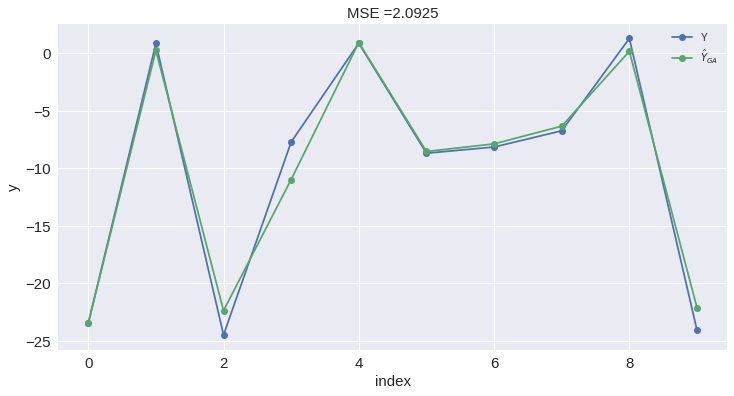

In [127]:
plt.figure(figsize = (12, 6));
plt.plot(list(range(0,N)), Y, '-o', label='Y')
plt.plot(list(range(0,N)), Y_bar_GA, '-o', label='$\hat{Y}_{GA}$')
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.xlabel('index', fontsize = 15);
plt.ylabel('y', fontsize = 15);
plt.legend()
plt.title('MSE =' + str(round(mse_GA, 4)), fontsize = 15);